In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize



In [3]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected=True)


def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x=df.index,
            y=df[column],
            mode='lines',
            name=column
        )
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

dataset = pd.read_csv('dataset/hour_online.csv', index_col=['Time'], parse_dates=['Time'])
plotly_df(dataset, title = "Online users")

### Скользящая средняя


In [4]:
def moving_average(series, n):
    """Скользящая средняя за последний интервал"""
    return np.average(series[-n:])

moving_average(dataset['Users'], 24)

29858.333333333332

In [5]:
def plotMovingAverage(series, n):
    """
    series - dataframe with timeseries
    n - rolling window size 

    """
    rolling_mean = series.rolling(window=n).mean()
    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    plt.plot(dataset, label='Actual values')
    plt.legend(loc='upper left')
    plt.grid(True)
    

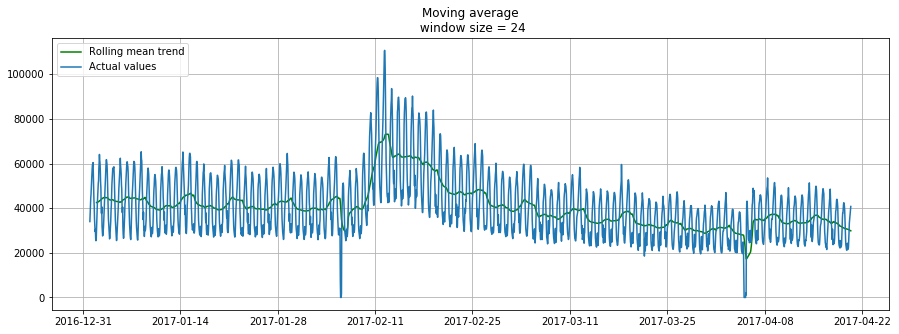

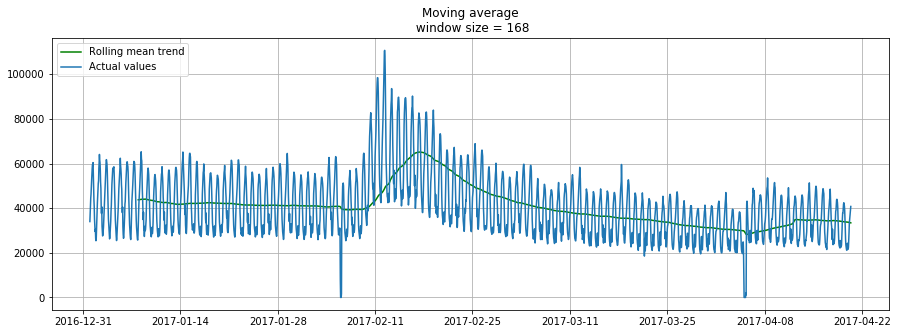

In [6]:
# сглаживание по дням
plotMovingAverage(dataset, 24)

# сглаживание по неделям
plotMovingAverage(dataset, 24*7)

In [7]:
dataset[:-5]

,Users
Time,
2017-01-01 00:00:00,34002
2017-01-01 01:00:00,37947
2017-01-01 02:00:00,41517
2017-01-01 03:00:00,44476
2017-01-01 04:00:00,46234
2017-01-01 05:00:00,48842
2017-01-01 06:00:00,52245
2017-01-01 07:00:00,55245
2017-01-01 08:00:00,57725


### Взвешенная средняя

In [8]:
def weighted_average(series, weights):
    result = 0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

weighted_average(dataset['Users'], [0.6, 0.2, 0.1, 0.07, 0.03])

35967.55

### Экспоненциальное сглаживание

Уровень

In [9]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

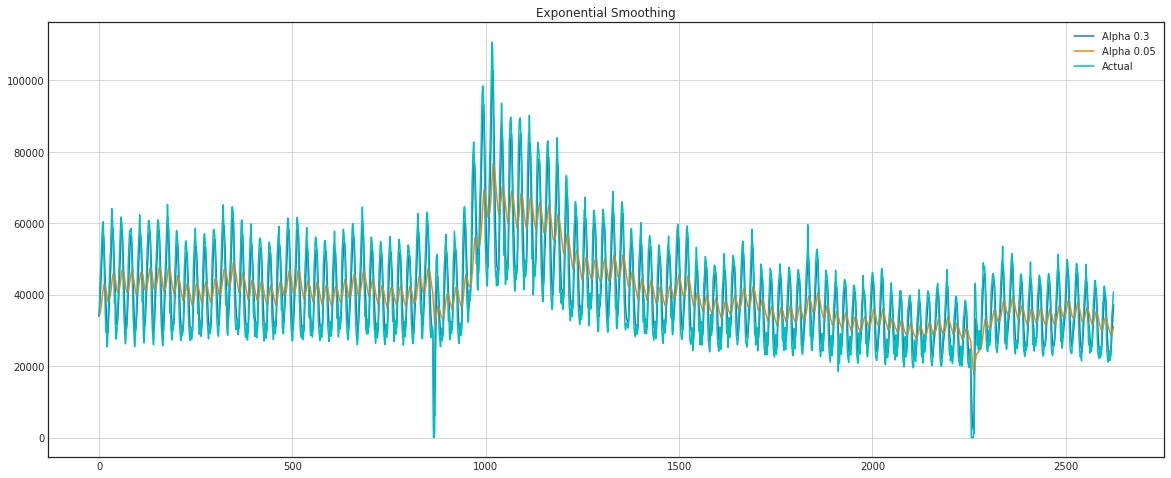

In [10]:
# отрисовка
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(dataset['Users'], alpha), label="Alpha {}".format(alpha))
    plt.plot(dataset['Users'].values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

### Двойное экспоненциальное сглаживание

Уровень + Тренд

In [11]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

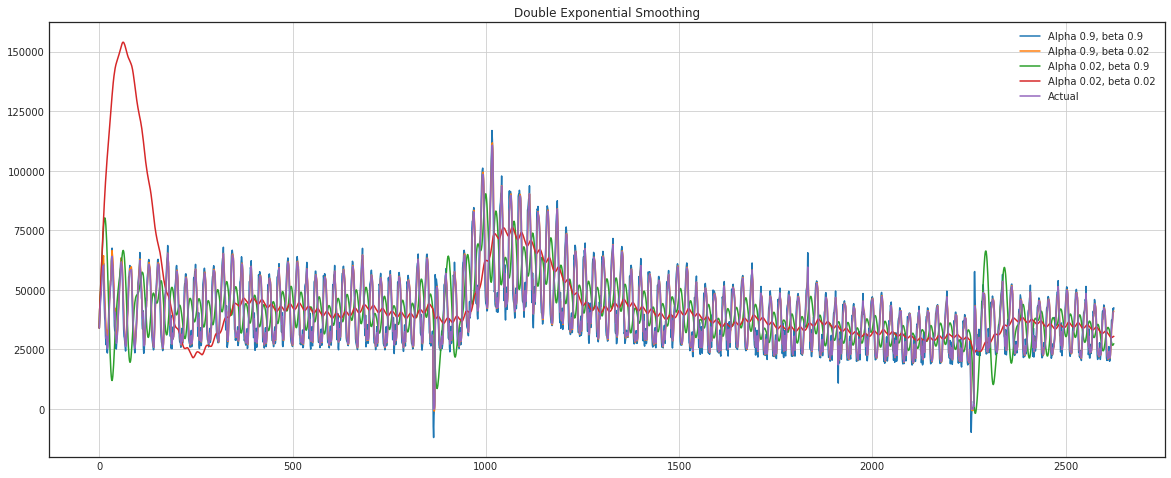

In [12]:
# Отрисовка
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(dataset['Users'], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset.Users.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

### Тройное экспоненциальное сглаживание a.k.a Holt-Winters 

Разобраться в этом говне 

Уровень + Тренд + Сезонность

In [13]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

### Кросс валидация на скользящем окне

In [14]:
def timeseriesCVscore(x):
    # вектор ошибок
    errors = []
    
    values = data.values
    alpha, beta, gamma = x
#     число фолдов на кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3)
    
# идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке
# и считаем ошибку
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen=24*7, alpha=alpha, 
                           beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(actual, predictions)
        errors.append(error)
        
    return np.mean(np.array(errors))
        
    

Значение длины сезона 24 * 7 возникло не случайно — в исходном ряде отчетливо видна дневная сезонность, (отсюда 24), и недельная — по будням ниже, на выходных — выше, (отсюда 7), суммарно сезонных компонент получится 24*7.

В модели Хольта-Винтерса, как и в остальных моделях экспоненциального сглаживания, есть ограничение на величину сглаживающих параметров — от 0 до 1, => для минимизации функции потерь нужно выбирать алгоритм, поддерживающий ограничения на параметры, в данном случае — Truncated Newton conjugate gradient.

In [15]:
%%time
data = dataset['Users'][:-500] # отложим часть данных для тестирования

x = [0, 0, 0]

opt = minimize(timeseriesCVscore, x0=x, method='TNC', bounds=((0, 1), (0, 1), (0, 1)))

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.006634267064344168 0.0 0.0467652042896729
Wall time: 1min 23s


Передадим полученные оптимальные значения коэффициентов ,  и  и построим прогноз на 5 дней вперёд (128 часов)

In [16]:
data = dataset['Users']
model = HoltWinters(data[:-128], slen=24*7, alpha=alpha_final, beta=beta_final,
                   gamma=gamma_final, n_preds=128, scaling_factor=2.56)
model.triple_exponential_smoothing()

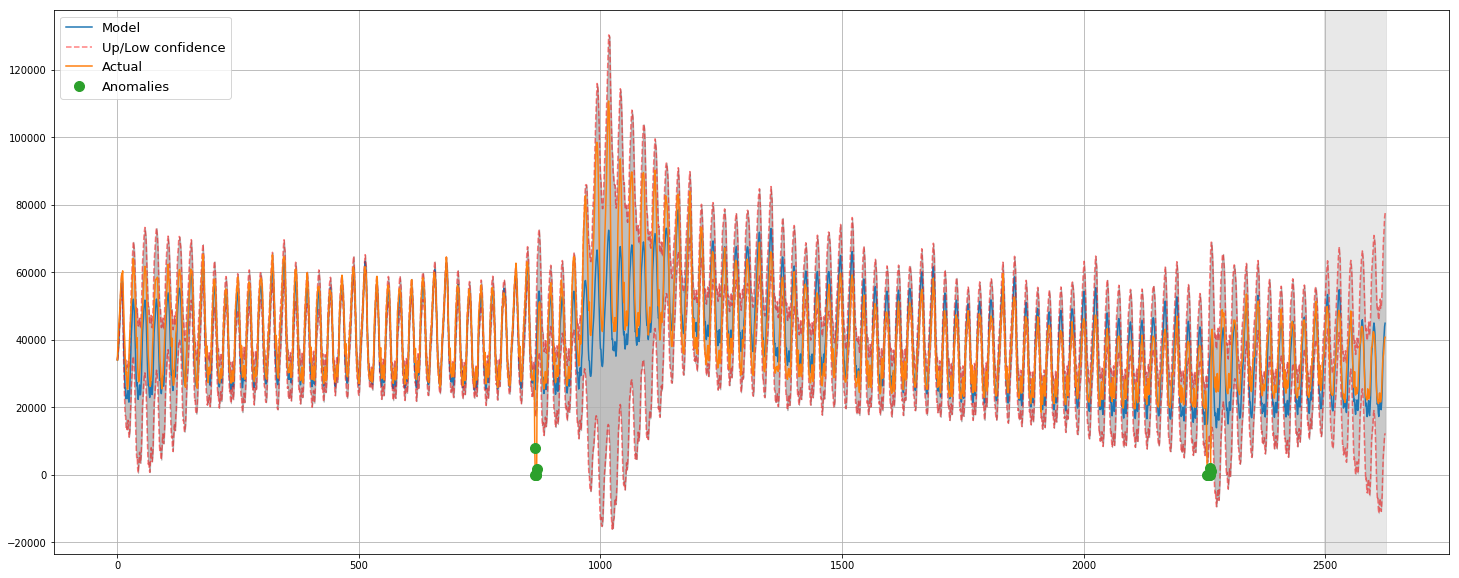

In [17]:
# отрисовка
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

plotHoltWinters()

Стационарность - свойство ряда сохранять матожидание и дисперсии с течением времени.

### Борьба с нестационарностью

In [18]:
white_noisy = np.random.normal(size=1000)
with plt.style.context('bmh'):
    plt.figure(figsize=(15, 5))
    plt.plot(white_noisy)


Итак, процесс, порожденный стандартным нормальным распределением, стационарен, колеблется вокруг нуля с отклонением в 1. Теперь на основании него сгенерируем новый процесс, в котором каждое последующее значение будет зависеть от предыдущего: $x_t = \rho x_{t-1} + e_t$

In [38]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    x1, w1 = x.copy(), w.copy()
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]
        x1[t] += rho * x[t-1]
        

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
    
    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x1)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x1)[1], 3)))

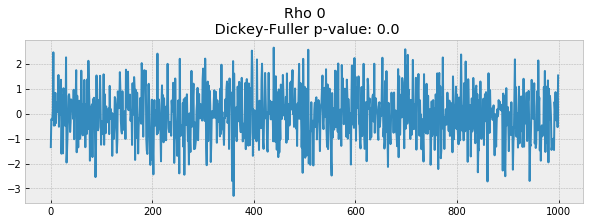

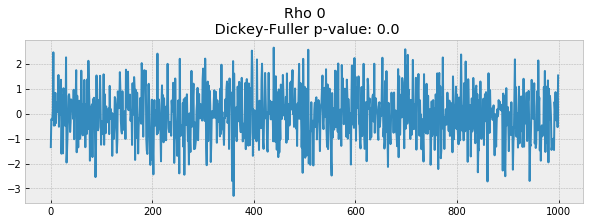

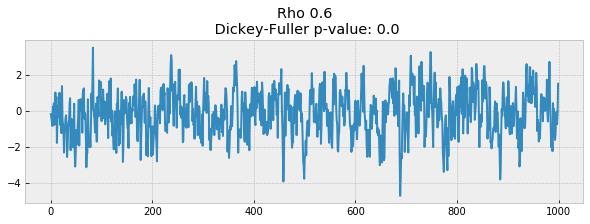

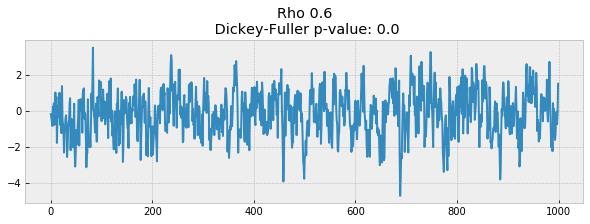

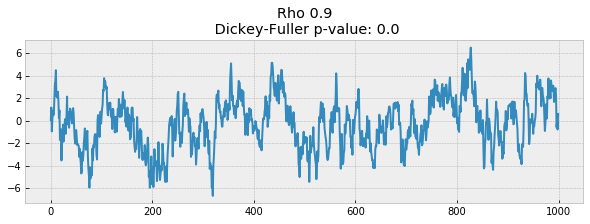

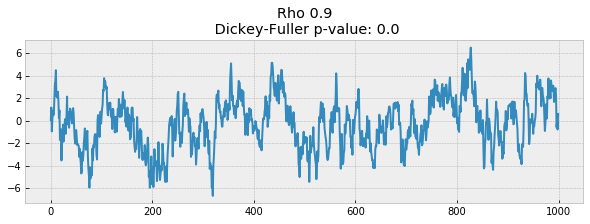

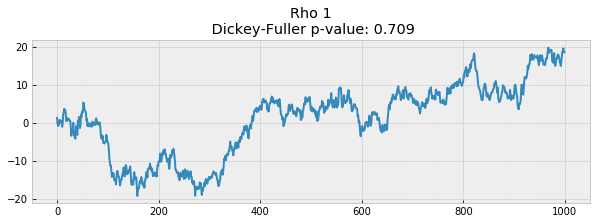

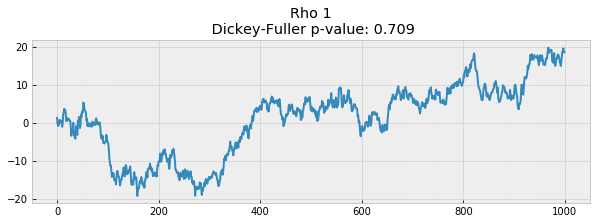

In [39]:
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

In [35]:
np.random.normal?

jupyter themes??, dask

metaprog

[??], custom cell, jupyterlab, 'hydrogen'